In [1]:
import numpy as np
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import time

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [3]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 109622954.23it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 35244601.05it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 64195926.86it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 14366914.61it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
test_dataset.targets

tensor([7, 2, 1,  ..., 4, 5, 6])

In [5]:
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]

test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]

In [6]:
train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

In [7]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=True)

In [80]:
from os.path import samefile
### КОД СЮДА ###

learning_rate = 0.01
epochs = 3

batch_size = 128
n_feat = 784
inner_feat = 500

w1 = np.random.rand(n_feat, inner_feat)*0.01 # 784x500
b1 = np.zeros(1)
w2 = np.random.rand(inner_feat, 1)*0.01 # 500x1
b2 = np.zeros(1)

losses = []

for n_epoch in range(epochs):

    print(f'Epoch: {n_epoch + 1}', losses)

    for x, y in train_loader:

        x = x.view(x.shape[0], -1).numpy() #приводим матрицу признаков к размерности 128x784 (b_s X n_feat)
        y = np.expand_dims(y.numpy(), 1) #приводим матрицу лэйблов к размерности 128x1

        z1 = (x @ w1) + b1 # 128x500 (b_s X inner_feat)
        a1 = 1 / (1 + np.exp(-z1)) # 128x500 (b_s X inner_feat)
        z2 = (a1 @ w2) + b2 # 128x1 (b_s X 1)
        a2 = 1 / (1 + np.exp(-z2)) # 128x1 (b_s X 1)

        bce = (-np.sum(np.multiply(y, np.log(a2)) + np.multiply((1-y), np.log(1-a2)))) / batch_size
        losses.append(bce)

        # backward
        dldp = (1-y)/(1-a2) # 128x1
        dpdz2 = np.multiply(a2, (1-a2)) # 128x1
        same = np.multiply(dldp, dpdz2) # 128x1
        same = a2 - y

        dldw2 = a1.T.dot(same) / batch_size # 500x1
        dldb2 = np.ones(batch_size).dot(same) / batch_size # 1x

        da1dz1 = np.ones((batch_size, inner_feat)) - ((np.exp(z1) - np.exp(-z1)) / (np.exp(z1) + np.exp(-z1))**2)
        new_same = np.multiply(same, np.multiply(w2.T, da1dz1)) # 128x500

        dldw1 = x.T @ new_same
        dldb1 = np.ones((batch_size, batch_size)) @ new_same

        # gradient descent
        w2 = w2 - learning_rate * dldw2
        b2 = b2 - learning_rate * dldb2
        w1 = w1 - learning_rate * dldw1
        b1 = b1 - learning_rate * dldb1

Epoch: 1 []
Epoch: 2 [0.9525300490101521, 0.7297178398246396, 0.6291547747955168, 0.6082337298812752, 0.5810195731209744, 0.5420532572160529, 0.5158568441300335, 0.4727006504367192, 0.4483131414858681, 0.41640856518660485, 0.3974928765970663, 0.3513323163152684, 0.34285062016353407, 0.3190424880363779, 0.28654891868414, 0.2661579588734427, 0.21589209481445243, 0.2494569247309273, 0.19924951378653616, 0.2013034799815081, 0.1778196721870562, 0.1416712171269548, 0.19797643510046548, 0.17907941733402213, 0.15183722541425704, 0.1717996374763932, 0.12607797429658452, 0.1412879830715689, 0.12517277470238486, 0.1885970511366455, 0.15093455808047684, 0.15452580265846438, 0.13110365766801052, 0.11252661152316125, 0.1440134715069839, 0.10938060526187593, 0.15634339511986997, 0.10128162779854727, 0.1303535287614884, 0.10498760843359174, 0.09385405059765414, 0.13515897366681912, 0.19421467837540055, 0.11650972006053253, 0.11408137647087319, 0.1478873068834648, 0.1961797936014746, 0.0701411767316748

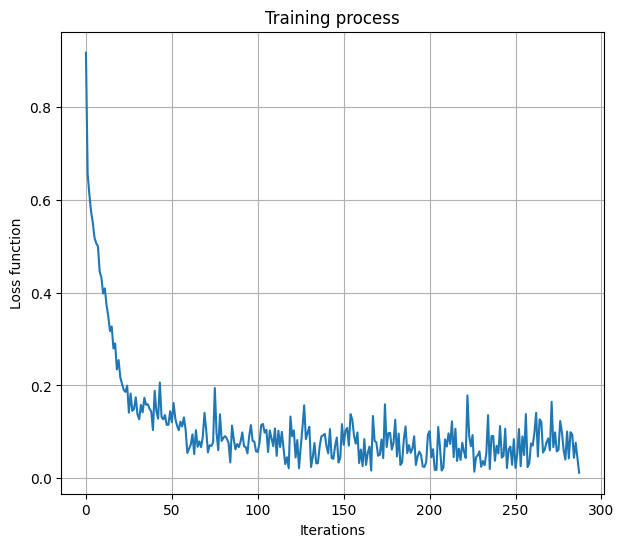

In [78]:
plt.figure(figsize=(7, 6))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');

In [79]:
losses_test = []
predicted = []
true_lbls = []

for x, y in test_loader:

  x = x.view(x.shape[0], -1).numpy()
  y = np.expand_dims(y.numpy(), 1)

  h1 = x.dot(w1) + b1 #переход в одномерное пространство
  p = 1/(1+np.exp(-h1)) #преобразование в "вероятности"

  bce = (-np.sum(np.multiply(np.log(p), y) + np.multiply((1 - y), np.log(1 - p)))) / batch_size
  #расчет энтропии с усреднением по размеру бача

  losses_test.append(bce)
  predicted.extend(p)
  true_lbls.extend(y)

<ipython-input-79-3856c042f1b2>:13: RuntimeWarning: divide by zero encountered in log
  bce = (-np.sum(np.multiply(np.log(p), y) + np.multiply((1 - y), np.log(1 - p)))) / batch_size
